In [ ]:
#| default_exp deepfluoro

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from pathlib import Path
from typing import Optional, Union

import h5py
import numpy as np
import torch
from beartype import beartype

from diffpose.calibration import RigidTransform, perspective_projection

# `DeepFluoro`

In [ ]:
#| export
@beartype
class DeepFluoroDataset(torch.utils.data.Dataset):
    """
    Get X-ray projections and poses from specimens in the `DeepFluoro` dataset.

    Given a specimen ID and projection index, returns the projection and the camera matrix for DiffDRR.
    """

    def __init__(
        self,
        id_number: int,  # Specimen number (1-6)
        filename: Optional[Union[str, Path]] = None,  # Path to DeepFluoro h5 file
        preprocess: bool = True,  # Preprocess X-rays
    ):
        # Load the volume
        (
            self.specimen,
            self.projections,
            self.volume,
            self.spacing,
            self.lps2volume,
            self.intrinsic,
            self.extrinsic,
            self.focal_len,
            self.x0,
            self.y0,
        ) = load_deepfluoro_dataset(id_number, filename)
        self.preprocess = preprocess

        # Get the isocenter pose (AP viewing angle at volume isocenter)
        isocenter_rot = torch.tensor([[torch.pi / 2, 0.0, -torch.pi / 2]])
        isocenter_xyz = torch.tensor(self.volume.shape) * self.spacing / 2
        isocenter_xyz = isocenter_xyz.unsqueeze(0)
        self.isocenter_pose = RigidTransform(
            isocenter_rot, isocenter_xyz, "euler_angles", "ZYX"
        )

        # Camera matrices and fiducials for the specimen
        self.fiducials = get_3d_fiducials(self.specimen)

        # Miscellaneous transformation matrices for wrangling SE(3) poses
        self.flip_xz = RigidTransform(
            torch.tensor([[0.0, 0.0, -1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0]]),
            torch.zeros(3),
        )
        self.translate = RigidTransform(
            torch.eye(3),
            torch.tensor([-self.focal_len / 2, 0.0, 0.0]),
        )
        self.flip_180 = RigidTransform(
            torch.tensor([[1.0, 0.0, 0.0], [0.0, -1.0, 0.0], [0.0, 0.0, -1.0]]),
            torch.zeros(3),
        )

    def __len__(self):
        return len(self.projections)

    def __iter__(self):
        return iter(self[idx] for idx in range(len(self)))

    def __getitem__(self, idx):
        """
        (1) Swap the x- and z-axes
        (2) Reverse the x-axis to make the matrix E(3) -> SE(3)
        (3) Move the camera to the origin
        (4) Rotate the detector plane by 180, if offset
        (5) Form the full SE(3) transformation matrix
        """
        projection = self.projections[f"{idx:03d}"]
        img = torch.from_numpy(projection["image/pixels"][:])
        world2volume = torch.from_numpy(projection["gt-poses/cam-to-pelvis-vol"][:])
        world2volume = RigidTransform(world2volume[:3, :3], world2volume[:3, 3])
        pose = convert_deepfluoro_to_diffdrr(self, world2volume)

        # Handle rotations in the imaging dataset
        if self._rot_180_for_up(idx):
            img = torch.rot90(img, k=2)
            pose = self.flip_180.compose(pose)

        # Optionally, preprocess the images
        img = img.unsqueeze(0).unsqueeze(0)
        if self.preprocess:
            img = preprocess(img)

        return img, pose

    def get_2d_fiducials(self, idx, pose):
        # Get the fiducials from the true camera pose
        _, true_pose = self.__getitem__(idx)
        extrinsic = (
            self.lps2volume.inverse()
            .compose(true_pose.inverse())
            .compose(self.translate)
            .compose(self.flip_xz)
        )
        true_fiducials = perspective_projection(
            extrinsic, self.intrinsic, self.fiducials
        )

        # Get the fiducials from the predicted camera pose
        extrinsic = (
            self.lps2volume.inverse()
            .compose(pose.cpu().inverse())
            .compose(self.translate)
            .compose(self.flip_xz)
        )
        pred_fiducials = perspective_projection(
            extrinsic, self.intrinsic, self.fiducials
        )

        if self.preprocess:
            true_fiducials -= 50
            pred_fiducials -= 50

        return true_fiducials, pred_fiducials

    def _rot_180_for_up(self, idx):
        return self.projections[f"{idx:03d}"]["rot-180-for-up"][()]

In [ ]:
#| export
def convert_deepfluoro_to_diffdrr(specimen, pose: RigidTransform):
    """Transform the camera coordinate system used in DeepFluoro to the convention used by DiffDRR."""
    return (
        specimen.translate.compose(specimen.flip_xz)
        .compose(specimen.extrinsic.inverse())
        .compose(pose)
        .compose(specimen.lps2volume.inverse())
    )


def convert_diffdrr_to_deepfluoro(specimen, pose: RigidTransform):
    """Transform the camera coordinate system used in DiffDRR to the convention used by DeepFluoro."""
    return (
        specimen.lps2volume.inverse()
        .compose(pose.inverse())
        .compose(specimen.translate)
        .compose(specimen.flip_xz)
    )

In [ ]:
#| export
from torch.nn.functional import pad

from diffpose.calibration import perspective_projection


class Evaluator:
    def __init__(self, specimen, idx):
        # Save matrices to device
        self.translate = specimen.translate
        self.flip_xz = specimen.flip_xz
        self.intrinsic = specimen.intrinsic
        self.intrinsic_inv = specimen.intrinsic.inverse()

        # Get gt fiducial locations
        self.specimen = specimen
        self.fiducials = specimen.fiducials
        gt_pose = specimen[idx][1]
        self.true_projected_fiducials = self.project(gt_pose)

    def project(self, pose):
        extrinsic = convert_diffdrr_to_deepfluoro(self.specimen, pose)
        x = perspective_projection(extrinsic, self.intrinsic, self.fiducials)
        x = -self.specimen.focal_len * torch.einsum(
            "ij, bnj -> bni",
            self.intrinsic_inv,
            pad(x, (0, 1), value=1),  # Convert to homogenous coordinates
        )
        extrinsic = (
            self.flip_xz.inverse().compose(self.translate.inverse()).compose(pose)
        )
        return extrinsic.transform_points(x)

    def __call__(self, pose):
        pred_projected_fiducials = self.project(pose)
        registration_error = (
            (self.true_projected_fiducials - pred_projected_fiducials)
            .norm(dim=-1)
            .mean()
        )
        registration_error *= 0.194  # Pixel spacing is 0.194 mm / pixel isotropic
        return registration_error

In [ ]:
#| exporti
from diffdrr.utils import parse_intrinsic_matrix


def load_deepfluoro_dataset(id_number, filename):
    # Open the H5 file for the dataset
    if filename is None:
        root = Path(__file__).parent.parent.absolute()
        filename = root / "data/ipcai_2020_full_res_data.h5"
    f = h5py.File(filename, "r")
    (
        intrinsic,
        extrinsic,
        num_cols,
        num_rows,
        proj_col_spacing,
        proj_row_spacing,
    ) = parse_proj_params(f)
    focal_len, x0, y0 = parse_intrinsic_matrix(
        intrinsic,
        num_rows,
        num_cols,
        proj_row_spacing,
        proj_col_spacing,
    )

    # Try to load the particular specimen
    assert id_number in {1, 2, 3, 4, 5, 6}
    specimen_id = [
        "17-1882",
        "18-1109",
        "18-0725",
        "18-2799",
        "18-2800",
        "17-1905",
    ][id_number - 1]
    specimen = f[specimen_id]
    projections = specimen["projections"]

    # Parse the volume
    volume, spacing, lps2volume = parse_volume(specimen)
    return (
        specimen,
        projections,
        volume,
        spacing,
        lps2volume,
        intrinsic,
        extrinsic,
        focal_len,
        x0,
        y0,
    )


def parse_volume(specimen):
    # Parse the volume
    spacing = specimen["vol/spacing"][:].flatten()
    volume = specimen["vol/pixels"][:].astype(np.float32)
    volume = np.swapaxes(volume, 0, 2)[::-1].copy()

    # Parse the translation matrix from LPS coordinates to volume coordinates
    origin = torch.from_numpy(specimen["vol/origin"][:].flatten())
    lps2volume = RigidTransform(torch.eye(3), origin)
    return volume, spacing, lps2volume


def parse_proj_params(f):
    proj_params = f["proj-params"]
    extrinsic = torch.from_numpy(proj_params["extrinsic"][:])
    extrinsic = RigidTransform(extrinsic[..., :3, :3], extrinsic[:3, 3])
    intrinsic = torch.from_numpy(proj_params["intrinsic"][:])
    num_cols = float(proj_params["num-cols"][()])
    num_rows = float(proj_params["num-rows"][()])
    proj_col_spacing = float(proj_params["pixel-col-spacing"][()])
    proj_row_spacing = float(proj_params["pixel-row-spacing"][()])
    return intrinsic, extrinsic, num_cols, num_rows, proj_col_spacing, proj_row_spacing


def get_3d_fiducials(specimen):
    fiducials = []
    for landmark in specimen["vol-landmarks"]:
        pt_3d = specimen["vol-landmarks"][landmark][:]
        pt_3d = torch.from_numpy(pt_3d)
        fiducials.append(pt_3d)
    return torch.stack(fiducials, dim=0).permute(2, 0, 1)

In [ ]:
#| export
from torchvision.transforms.functional import center_crop, gaussian_blur


def preprocess(img, size=None, initial_energy=torch.tensor(65487.0)):
    """
    Recover the line integral: $L[i,j] = \log I_0 - \log I_f[i,j]$

    (1) Remove edge due to collimator
    (2) Smooth the image to make less noisy
    (3) Subtract the log initial energy for each ray
    (4) Recover the line integral image
    (5) Rescale image to [0, 1]
    """
    img = center_crop(img, (1436, 1436))
    img = gaussian_blur(img, (5, 5), sigma=1.0)
    img = initial_energy.log() - img.log()
    img = (img - img.min()) / (img.max() - img.min())
    return img

## Basic functionalities

`DeepFluoroDataset` is a `torch.utils.data.Dataset` that stores imaging data (`volume`, `spacing`, and `focal_len`) and provides an API for getting X-ray images and associated camera poses. The imaging data can be passed to a `diffdrr.drr.DRR` to render DRRs from a specific patient.

In [ ]:
#| eval: false
import matplotlib.pyplot as plt
from diffdrr.drr import DRR
from tqdm import tqdm

In [ ]:
#| eval: false
filename = "../../data/ipcai_2020_full_res_data.h5"
specimen = DeepFluoroDataset(1, filename=filename, preprocess=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

height = 1536 - 100
dx = 0.194
drr = DRR(
    specimen.volume,
    specimen.spacing,
    sdr=specimen.focal_len / 2,
    height=height,
    delx=dx,
    x0=specimen.x0,
    y0=specimen.y0,
    reverse_x_axis=True,
    patch_size=359,
).to(device)

In [ ]:
#| eval: false
# Rotate the C-arm by the pose parameters to recover the original image
true_xray, pose = specimen[0]
pred_xray = drr(None, None, None, pose=pose.to(device))

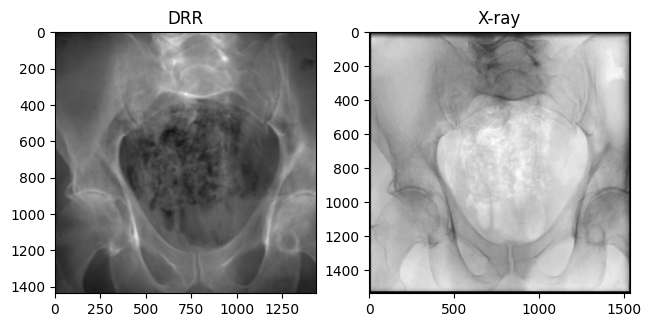

In [ ]:
#| label: bone_attenuation_multiplier=1.0
#| code-fold: true
#| eval: false
plt.figure(constrained_layout=True)
plt.subplot(121)
plt.title("DRR")
plt.imshow(pred_xray.squeeze().cpu().numpy(), cmap="gray")
plt.subplot(122)
plt.title("X-ray")
plt.imshow(true_xray.squeeze(), cmap="gray")
plt.show()

### Preprocessing X-rays

The true X-ray images need to be processed before they look like our DRRs:

- Crop 50 pixels off each edge to remove the effects of the collimator
- Invert the imaging equation to recover the line integral radiograph
- Rescale the image to [0, 1]

From the Beer-Lambert Law, the equation governing fluoroscopy images is
\begin{equation}
    I_f[i, j] = I_0 \exp(-L[i, j]) \,,
\end{equation}
where $L[i, j]$ is the line integral of an X-ray through the volume. 
Inverting this, we recover 
\begin{equation}
    L[i,j] = \log I_0 - \log I_f[i,j] \,,
\end{equation}
where the constant $I_0$ for each image represents the initial energy of each ray. We approximate $I_0 = \max_{i,j} I_f[i,j]$, assuming that this represents a ray that reached the detector plane without first intersecting the volume.

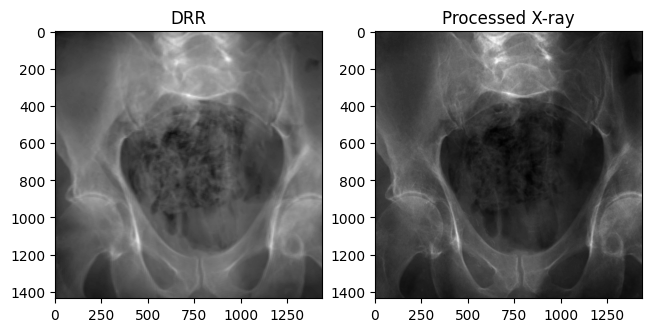

In [ ]:
#| code-fold: true
#| eval: false
specimen = DeepFluoroDataset(
    1,
    filename=filename,
    preprocess=True,  # Set as True to preprocess images
)
processed_xray, _ = specimen[0]

plt.figure(constrained_layout=True)
plt.subplot(121)
plt.title("DRR")
plt.imshow(pred_xray.squeeze().cpu().numpy(), cmap="gray")
plt.subplot(122)
plt.title("Processed X-ray")
plt.imshow(processed_xray.squeeze(), cmap="gray")
plt.show()

### Changing bone attenuation for DRRs

We can preprocess the CT by segmenting air, soft tissue, and bone before generating DRRs.

- Using `bone_attenuation_multiplier = 1.0` (default) sets the value of air voxels to 0
- Increasing `bone_attenuation_multiplier` weights the density of bones higher than that of soft tissue (i.e., increases contrast in the DRR)

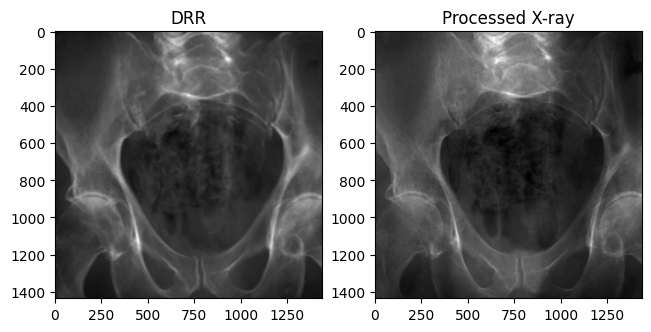

In [ ]:
#| label: bone_attenuation_multiplier = 2.5
#| code-fold: true
#| eval: false
drr = DRR(
    specimen.volume,
    specimen.spacing,
    sdr=specimen.focal_len / 2,
    height=height,
    delx=dx,
    x0=specimen.x0,
    y0=specimen.y0,
    reverse_x_axis=True,
    patch_size=359,
).to(device)

_, pose = specimen[0]
pred_xray = drr(
    rotation=pose.get_rotation().to(device),
    translation=pose.get_translation().to(device),
    parameterization="matrix",
    bone_attenuation_multiplier=2.5,  # Set the bone attenuation multiplier
)

plt.figure(constrained_layout=True)
plt.subplot(121)
plt.title("DRR")
plt.imshow(pred_xray.squeeze().cpu().numpy(), cmap="gray")
plt.subplot(122)
plt.title("Processed X-ray")
plt.imshow(processed_xray.squeeze(), cmap="gray")
plt.show()

Our DRR generated from the ground truth C-arm pose looks remarkably similar to the real X-ray!

### Rotated X-ray test

Some X-ray images in the dataset are rotated 180 degrees. If the X-rays below are in the same orientation, this error in the dataset has been handled properly.

In [ ]:
#| eval: false
true_xray, pose = specimen[34]
pred_xray = drr(
    rotation=pose.get_rotation().to(device),
    translation=pose.get_translation().to(device),
    parameterization="matrix",
)

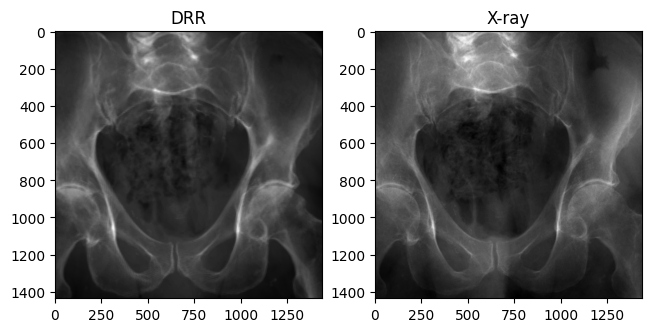

In [ ]:
#| eval: false
#| code-fold: true
plt.figure(constrained_layout=True)
plt.subplot(121)
plt.title("DRR")
plt.imshow(pred_xray.squeeze().cpu().numpy(), cmap="gray")
plt.subplot(122)
plt.title("X-ray")
plt.imshow(true_xray.squeeze(), cmap="gray")
plt.show()

## Fiducial markers

The `DeepFluoroDataset` class also contains a method for evaluating the registration error for a predicted pose. Fiducial markers were implanted in the original cadavers. Projecting them with predicted pose parameters can be used to measure their distance from the true fiducials.

In [ ]:
#| eval: false
# from pytorch3d.transforms import euler_angles_to_matrix, matrix_to_euler_angles
from diffdrr.utils import convert

# Perturb the ground truth rotations by 0.05 degrees and 2 mm
idx = 0
_, pose = specimen[idx]
euler_angles = (
    convert(pose.get_rotation(), "matrix", "euler_angles", output_convention="ZYX")
    + 0.05
)
R = convert(euler_angles, "euler_angles", "matrix", input_convention="ZYX")
t = pose.get_translation() + 2.0
pred_pose = RigidTransform(R, t)
pred_xray = drr(
    rotation=None,
    translation=None,
    parameterization=None,
    pose=pred_pose.to(device),
)

# Get the fiducials
true_fiducials, pred_fiducials = specimen.get_2d_fiducials(idx, pred_pose)

evaluator = Evaluator(specimen, idx)
registration_error = evaluator(pred_pose).item()
print(f"Registration error = {registration_error} mm")

Registration error = 2.3423616886138916 mm


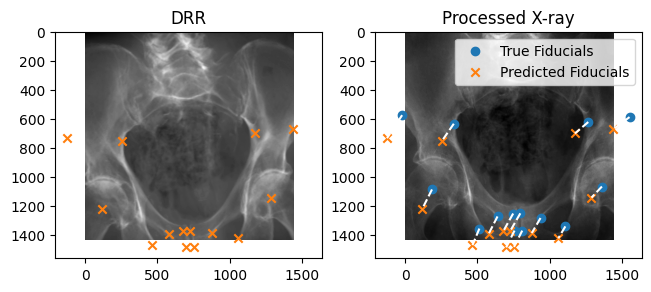

In [ ]:
#| eval: false
#| code-fold: true
plt.figure(constrained_layout=True)
ax = plt.subplot(121)
plt.title("DRR")
plt.imshow(pred_xray.squeeze().cpu().numpy(), cmap="gray")
plt.scatter(
    pred_fiducials[0, ..., 0],
    pred_fiducials[0, ..., 1],
    marker="x",
    c="tab:orange",
)
plt.subplot(122, sharex=ax, sharey=ax)
plt.title("Processed X-ray")
plt.imshow(processed_xray.squeeze(), cmap="gray")
plt.scatter(
    true_fiducials[0, ..., 0],
    true_fiducials[0, ..., 1],
    label="True Fiducials",
)
plt.scatter(
    pred_fiducials[0, ..., 0],
    pred_fiducials[0, ..., 1],
    marker="x",
    c="tab:orange",
    label="Predicted Fiducials",
)
for idx in range(true_fiducials.shape[1]):
    plt.plot(
        [true_fiducials[..., idx, 0].item(), pred_fiducials[..., idx, 0].item()],
        [true_fiducials[..., idx, 1].item(), pred_fiducials[..., idx, 1].item()],
        "w--",
    )
plt.legend()
plt.show()

## Deep learning transforms

We transform X-rays and DRRs before inputting them to a deep learning model by

- Rescaling pixels to [0, 1]
- Resizing the images to a specified size
- Normalizing pixels by the mean and std dev

In [ ]:
#| eval: false
#| code-fold: true
mean, vars = [], []
for idx in range(1, 7):
    specimen = DeepFluoroDataset(idx, filename=filename)
    for img, _ in tqdm(specimen, ncols=50):
        img = (img - img.min()) / (img.max() - img.min())
        mean.append(img.mean())
        vars.append(img.var())

print("Pixel mean :", sum(mean) / len(mean))
print("Pixel std dev :", (sum(vars) / len(vars)).sqrt())

100%|█████████████| 24/24 [00:04<00:00,  5.40it/s]

Pixel mean : tensor(0.3080)
Pixel std dev : tensor(0.1494)


In [ ]:
#| export
from torchvision.transforms import Compose, Lambda, Normalize, Resize


class Transforms:
    def __init__(
        self,
        size: int,  # Dimension to resize image
        eps: float = 1e-6,
    ):
        """Transform X-rays and DRRs before inputting to CNN."""
        self.transforms = Compose(
            [
                Lambda(lambda x: (x - x.min()) / (x.max() - x.min() + eps)),
                Resize((size, size), antialias=True),
                Normalize(mean=0.3080, std=0.1494),
            ]
        )

    def __call__(self, x):
        return self.transforms(x)

In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()